### Interpretable Image Classification Car vs Non-Car Using VGG16 and Keras

#####Classifying Uploaded Image Car Vs No-Car Using VGG16 and Keras


Importing required libraries:

In [ ]:
import os
import h5py
import urllib.request
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pk
from IPython.display import Image, display, clear_output
from collections import Counter, defaultdict
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
from keras import optimizers
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.utils import get_file
from keras.utils import to_categorical
from keras.preprocessing.image import img_to_array, array_to_img, load_img
from keras.models import Sequential, load_model
from keras.callbacks import ModelCheckpoint, History

There is ImageNet class index file hosted by Keras on AWS.

This file maps each of the 1,000 ImageNet class indices to their corresponding WordNet ID and human-readable label and here that json file is set to CLASS_INDEX_PATH which will be used later.

In [ ]:
CLASS_INDEX = None
CLASS_INDEX_PATH = 'https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json'

Loading the VGG16, VGG19 and ResNet50 three powerful pretrained convolutional neural networks from Keras, each trained on the ImageNet dataset

In [ ]:
vgg16 = VGG16(weights='imagenet')
vgg19 = VGG19(weights='imagenet')
resnet = ResNet50(weights='imagenet')

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
574710816/574710816 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step
102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Below *prepare_image_224* function to preprocess images for models like VGG16, VGG19 and ResNet50, where all models expect inputs of shape (224, 224, 3) and specific normalization


In [ ]:
def prepare_image_224(img_path):
    img = load_img(img_path, target_size=(224,224))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

*get_predictions* decodes the raw output of an ImageNet model (like ResNet50 or VGG16) into human-readable labels and confidence scores, it is similar to Keras decode_predictions but in a customized way.

In [ ]:
def get_predictions(preds, top=5):
    global CLASS_INDEX
    if len(preds.shape) != 2 or preds.shape[1] != 1000:
        raise ValueError('decode_predictions` expects a batch of predictions (i.e. a 2D array of shape (samples, 1000)). Found array with shape: ' + str(preds.shape))
    if CLASS_INDEX is None:
        fpath = get_file('imagenet_class_index.json',CLASS_INDEX_PATH,cache_subdir='models')
        CLASS_INDEX = json.load(open(fpath))
    results = []
    for pred in preds:
        top_indices = pred.argsort()[-top:][::-1]
        result = [tuple(CLASS_INDEX[str(i)]) + (pred[i],) for i in top_indices]
        result.sort(key=lambda x: x[2], reverse=True)
        results.append(result)
    return results

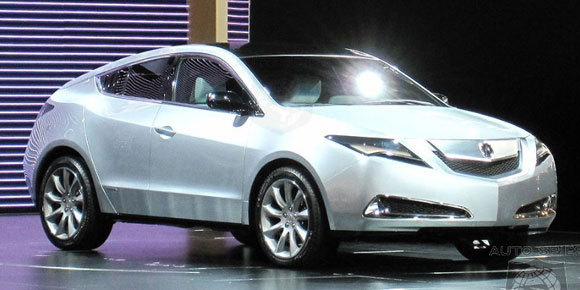

In [ ]:
Image('/content/0025.jpg')

Getting predictions for all 3 models and plotting them to see confidence.

In [ ]:
a = prepare_image_224('/content/0025.jpg')
preds = vgg16.predict(a)
print(get_predictions(preds, top=5))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
[[('n04285008', 'sports_car', np.float32(0.21244866)), ('n03770679', 'minivan', np.float32(0.15620661)), ('n02930766', 'cab', np.float32(0.13607934)), ('n04037443', 'racer', np.float32(0.13289374)), ('n02814533', 'beach_wagon', np.float32(0.09646093))]]


In [ ]:
b = prepare_image_224('/content/0025.jpg')
preds = vgg19.predict(b)
print(get_predictions(preds, top=5))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
[[('n04285008', 'sports_car', np.float32(0.381635)), ('n04037443', 'racer', np.float32(0.18541741)), ('n02814533', 'beach_wagon', np.float32(0.1155347)), ('n02974003', 'car_wheel', np.float32(0.08006756)), ('n03459775', 'grille', np.float32(0.07241956))]]


In [ ]:
c = prepare_image_224('/content/0025.jpg')
preds = resnet.predict(c)
print(get_predictions(preds))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
[[('n03459775', 'grille', np.float32(0.73468)), ('n04285008', 'sports_car', np.float32(0.1119551)), ('n02974003', 'car_wheel', np.float32(0.04184438)), ('n04037443', 'racer', np.float32(0.041216116)), ('n02930766', 'cab', np.float32(0.019558461))]]


In [ ]:
def plot_top_predictions(img_path, models, model_names, get_predictions_fn, top=5):
    x = prepare_image_224(img_path)
    fig, axes = plt.subplots(1, len(models), figsize=(16, 5), sharey=True)

    for ax, model, name in zip(axes, models, model_names):
        preds = model.predict(x)
        top_preds = get_predictions_fn(preds, top=top)[0]

        labels = [label for (_, label, _) in top_preds]
        scores = [score for (_, _, score) in top_preds]

        ax.barh(labels[::-1], scores[::-1], color='gray')
        ax.set_title(name)
        ax.set_xlim(0, 1)
        ax.set_xlabel("Confidence")
        ax.invert_yaxis()

    plt.tight_layout()
    plt.suptitle("Top-5 Predictions per Model", fontsize=16, y=1.05)
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


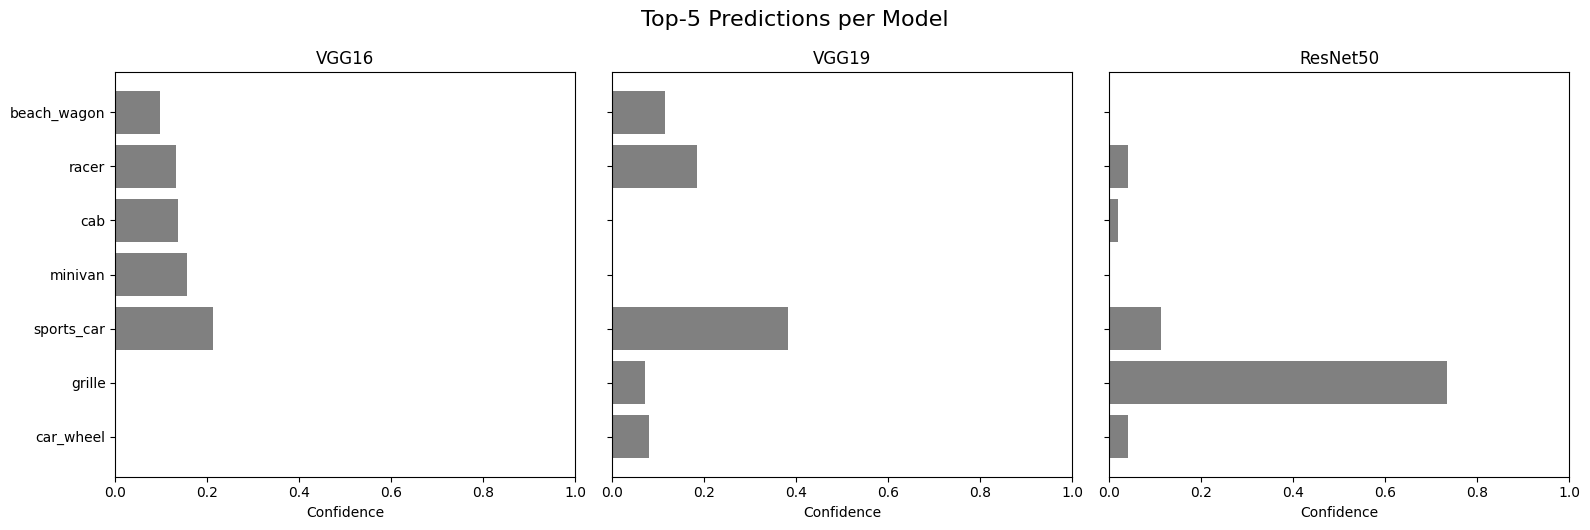

In [ ]:
plot_top_predictions('/content/0025.jpg',
    [vgg16, vgg19, resnet],
    ['VGG16', 'VGG19', 'ResNet50'],
    get_predictions,
    top=5
)


Overall we can say that vgg16 shows good confidence over those top 5 predictions, hence using the same to get car categories.

The *data* folder has 200 images of whole and damaged car images and folder structure looks like as below:
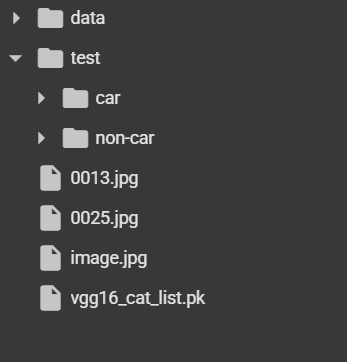

In [ ]:
def get_car_categories():
    d = defaultdict(float)
    img_list = os.listdir('/content/data')
    for i, img_path in enumerate(img_list):
        img = prepare_image_224('/content/data/'+img_path)
        out = vgg16.predict(img)
        preds = get_predictions(out,top=5)
        for pred in preds[0]:
          if 'warplane' not in pred:
            d[pred[0:2]]+=pred[2]
        if(i%50==0):
            print(i,'/',len(img_list),'complete')
    return Counter(d)

After running below code, the Counter is printed at the end - each key is a predicted category label and each value is the aggregated confidence score across all images.


In [ ]:
categ_count = get_car_categories()
print(categ_count)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
0 / 200 complete
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/

Now saving and loading the category count got above.

In [ ]:
with open('/content/vgg16_cat_list.pk', 'wb') as f:
    pk.dump(categ_count, f, -1)

In [ ]:
with open('/content/vgg16_cat_list.pk', 'rb') as f:
    categ_count = pk.load(f)

Extracting the top 50 predicted categories from your categ_count object.


In [ ]:
categ_list = [k for k, v in categ_count.most_common()[:50]]

In [ ]:
def get_car_categories(categ_list):
    img_list = os.listdir('/content/data')
    n = 0
    bad_list = []
    for i, img_path in enumerate(img_list):
        img = prepare_image_224('/content/data/'+img_path)
        out = vgg16.predict(img)
        preds = get_predictions(out, top=5)
        for pred in preds[0]:
            if pred[0:2] in categ_list:
                n+=1
                break
            else:
                pass
            bad_list.append(img_path)
        if i%100 == 0:
            print(i,'/',len(img_list), 'complete')
    bad_list = [k for k, v in Counter(bad_list).items() if v == 5]
    return n, bad_list

In [ ]:
num, bad_list = get_car_categories(categ_list)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
0 / 200 complete
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/

In [ ]:
def classifyImage(image, categ_list):
    img = prepare_image_224(image)
    out = vgg16.predict(img)
    preds = get_predictions(out, top=5)
    print("Ensuring entered picture is a car...")
    for pred in preds[0]:
        if pred[0:2] in categ_list:
            print(pred[0:2])
            return "Successful. Proceeding to damage assessment..."
    return "The entered image is a not a car. Please try again. Consider a different angle or lighting."


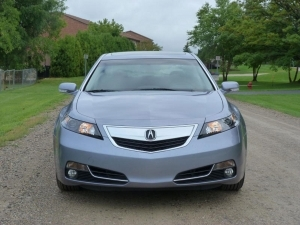

In [ ]:
Image('/content/0013.jpg')

In [ ]:
classifyImage('/content/0013.jpg', categ_list)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Ensuring entered picture is a car...
('n03770679', 'minivan')


'Successful. Proceeding to damage assessment...'

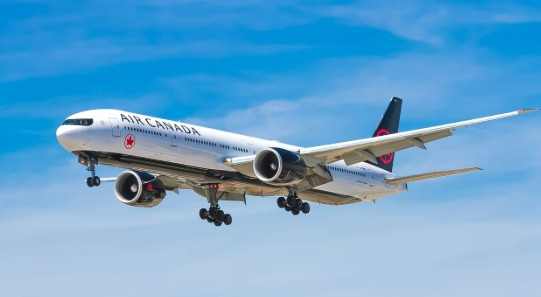

In [ ]:
Image('/content/image.jpg')

In [ ]:
classifyImage('/content/image.jpg', categ_list)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Ensuring entered picture is a car...


'The entered image is a not a car. Please try again. Consider a different angle or lighting.'

From above two results, it is visible that model can classify the car and non-car image from the given images

In [ ]:
print(categ_list)

[('n04285008', 'sports_car'), ('n03100240', 'convertible'), ('n03770679', 'minivan'), ('n02814533', 'beach_wagon'), ('n03670208', 'limousine'), ('n04037443', 'racer'), ('n02974003', 'car_wheel'), ('n03930630', 'pickup'), ('n03459775', 'grille'), ('n03594945', 'jeep'), ('n04461696', 'tow_truck'), ('n02930766', 'cab'), ('n03977966', 'police_van'), ('n04252225', 'snowplow'), ('n02917067', 'bullet_train'), ('n02704792', 'amphibian'), ('n03478589', 'half_track'), ('n02965783', 'car_mirror'), ('n04467665', 'trailer_truck'), ('n03445924', 'golfcart'), ('n03417042', 'garbage_truck'), ('n03769881', 'minibus'), ('n04252077', 'snowmobile'), ('n02701002', 'ambulance'), ('n03127747', 'crash_helmet'), ('n03891332', 'parking_meter'), ('n02895154', 'breastplate'), ('n02747177', 'ashcan'), ('n04442312', 'toaster'), ('n04273569', 'speedboat'), ('n03345487', 'fire_engine'), ('n04049303', 'rain_barrel'), ('n03538406', 'horse_cart'), ('n03791053', 'motor_scooter'), ('n03649909', 'lawn_mower'), ('n04465501'

Here to see how classifyImage performs on unseen data - test folder has 2 subfolders cars and noncars with new unknown images

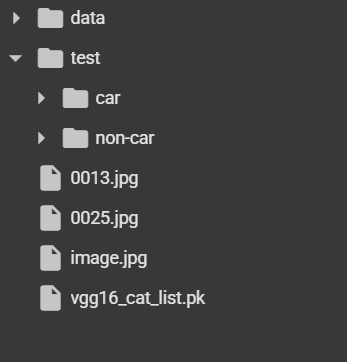

In [ ]:
def evaluate_car_classifier(cars_folder, non_cars_folder, categ_list):
    car_labels = set(label.lower() for (_, label) in categ_list)
    print(f"Car labels used for classification: {car_labels}")

    y_true = []
    y_pred = []
    misclassified = []

    def process_folder(folder_path, true_label):
        for filename in os.listdir(folder_path):
            if not filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                continue

            img_path = os.path.join(folder_path, filename)
            try:
                img = prepare_image_224(img_path)
                out = resnet.predict(img)
                preds = get_predictions(out, top=5)

                is_predicted_car = any(pred[1].lower() in car_labels for pred in preds[0])
                predicted_label = "car" if is_predicted_car else "non_car"

                y_true.append(true_label)
                y_pred.append(predicted_label)

                if predicted_label != true_label:
                    misclassified.append((filename, true_label, predicted_label))

            except Exception as e:
                print(f"Error processing {filename}: {e}")

    process_folder(cars_folder, "car")
    process_folder(non_cars_folder, "non_car")

    print("\n Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred, labels=["car", "non_car"]))

    print("\n Classification Report:")
    print(classification_report(y_true, y_pred, target_names=["car", "non_car"]))

    print(f"\n Misclassified images: {misclassified}")
    return y_true, y_pred, misclassified

In [ ]:
evaluate_car_classifier('/content/test/car','/content/test/non-car', categ_list)

Car labels used for classification: {'chain_saw', 'car_wheel', 'grey_whale', 'moving_van', 'wreck', 'minivan', 'racer', 'convertible', 'ashcan', 'toaster', 'bobsled', 'sports_car', 'golfcart', 'parking_meter', 'recreational_vehicle', 'trailer_truck', 'garbage_truck', 'bullet_train', 'half_track', 'cuirass', 'police_van', 'car_mirror', 'fire_engine', 'pickup', 'beach_wagon', 'tow_truck', 'speedboat', 'amphibian', 'minibus', 'ambulance', 'lawn_mower', 'tractor', 'limousine', 'cannon', 'jeep', 'sundial', 'power_drill', 'breastplate', 'snowplow', 'crash_helmet', 'model_t', 'forklift', 'rain_barrel', 'horse_cart', 'grille', 'cab', 'snowmobile', 'motor_scooter', 'trimaran', 'tank'}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━

(['car',
  'car',
  'car',
  'car',
  'car',
  'car',
  'car',
  'car',
  'car',
  'car',
  'non_car',
  'non_car',
  'non_car',
  'non_car'],
 ['car',
  'car',
  'car',
  'car',
  'car',
  'car',
  'car',
  'car',
  'car',
  'car',
  'non_car',
  'car',
  'non_car',
  'car'],
 [('another_image.jpg', 'non_car', 'car'), ('image2.jpg', 'non_car', 'car')])

From above metrics, we can say about model


Car classification metrics

- **Precision for classifying car**: 83% of predicted cars were actually cars.  
- **Recall for car**: 100% of actual cars were correctly identified.  
- **F1-score for car**: Balanced measure of precision and recall → 0.91  


Non-car classification metrics

- **Precision for classifying non-car**: 100% of predicted non-cars were actually non-cars.  
- **Recall for non-car**: 50% of actual non-car images were correctly identified.  
- **F1-score for non-car**: Balanced measure of precision and recall → 0.67  



Overall model performance

- **Accuracy**: 12 out of 14 predictions were correct → **86% accuracy**  
- **Macro average F1-score**: Average across both classes → **0.79**  
- **Weighted average F1-score**: Weighted by class support → **0.84**





The model demonstrates strong performance in identifying car images with perfect recall and a high F1-score of 0.91.

However, its ability to detect non-car images is less reliable, with recall dropping to 50%.

The overall accuracy is 86% and the imbalance between car and non-car samples (10 vs. 4) continues to influence macro-level metrics.

The model is confident when predicting cars but may benefit from improved generalization for non-car detection.

Next steps to consider:

- Class balancing: Add more non-car samples or apply oversampling techniques to improve recall.
- Error analysis: Inspect the two false negatives and understand why non-car images were misclassified.
- Threshold tuning: Adjust decision thresholds to better separate car and non-car predictions.
- Model calibration: Apply Platt scaling or isotonic regression to improve confidence estimates, especially for borderline cases.
